In [107]:
import numpy as np
import pandas as pd
import os
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/miniconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import sncosmo
import analyzeSN as ans

## Read Simulations

Download the simulations located at http://lsst.astro.washington.edu/simdata/SN_data/MINION/MINION_1016_SNANA_DDF_10yr_v2.tgz and un-tar them
```
tar -xzvf simulationDir
```
For me the resultant directory is at 
`/Users/rbiswas/data/LSST/SNANA_data/MINION_1016_10YR_DDF_v2`


In [4]:
!tree /Users/rbiswas/data/LSST/SNANA_data/MINION_1016_10YR_DDF_v2/

/Users/rbiswas/data/LSST/SNANA_data/MINION_1016_10YR_DDF_v2/
├── LSST_Ia_HEAD.FITS
├── LSST_Ia_PHOT.FITS
├── LSST_NONIa_HEAD.FITS
├── LSST_NONIa_PHOT.FITS
├── MINION_1016_10YR_DDF_v2.DUMP
├── MINION_1016_10YR_DDF_v2.FILTERS
│   ├── Y.dat
│   ├── g.dat
│   ├── i.dat
│   ├── r.dat
│   ├── u.dat
│   └── z.dat
├── MINION_1016_10YR_DDF_v2.IGNORE
├── MINION_1016_10YR_DDF_v2.LIST
├── MINION_1016_10YR_DDF_v2.README
└── misc
    ├── LSST_NONIa.README
    ├── LSST_SALT2.Guy10_LAMOPEN.README
    ├── SIMGEN_INCLUDE_NON1A.INPUT
    ├── SIMGEN_LSSTDEEP_Ia.input
    ├── SIMGEN_LSSTDEEP_NONIA.input
    └── SIMGEN_MASTER_LSST.INPUT

2 directories, 20 files


## Comparison of model and simulated data

We already know how to extract the data from the simulations. The data is the model light curve + noise. The model 
used here is SALT2, which has a few parameters `['x0', 'x1', 'c', 'z', 't0']`. We must estimate the values of these parameters from the data

In [5]:
simdata = ans.SNANASims.fromSNANAfileroot('LSST_Ia',
                                          location='/Users/rbiswas/data/LSST/SNANA_data/MINION_1016_10YR_DDF_v2/',
                                           coerce_inds2int=False)

In [6]:
simdata.headData.head()

,IAUC,FAKE,RA,DECL,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y
SNID,,,,,,,,,,,,,,,,,,,,,
13,NULL,2,0.000000,-45.524532,0.2,-9,-9,1,71,1,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
31,NULL,2,150.362350,2.836485,0.2,-9,-9,1,90,73,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
42,NULL,2,34.393394,-5.090329,0.2,-9,-9,1,80,164,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
61,NULL,2,349.386444,-63.321003,0.2,-9,-9,1,68,245,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
89,NULL,2,150.362350,2.836485,0.2,-9,-9,1,76,314,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [7]:
hd = simdata.headData.query('REDSHIFT_FINAL > 0.2 and REDSHIFT_FINAL < 0.25').head(5).copy()

In [8]:
hd

,IAUC,FAKE,RA,DECL,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y
SNID,,,,,,,,,,,,,,,,,,,,,
2341,NULL,2,0.000000,-45.524532,0.2,-9,-9,1,125,10191,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
14250,NULL,2,34.393394,-5.090329,0.2,-9,-9,1,60,58359,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
19827,NULL,2,0.000000,-45.524532,0.2,-9,-9,1,74,78209,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
22682,NULL,2,0.000000,-45.524532,0.2,-9,-9,1,123,91403,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
27034,NULL,2,53.009136,-27.438950,0.2,-9,-9,1,108,109925,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [9]:
lcobj = simdata.get_SNANA_photometry(snid='2341')

In [10]:
simdata.headData.ix['2341']

IAUC                      NULL    
FAKE                             2
RA                               0
DECL                      -45.5245
PIXSIZE                        0.2
NXPIX                           -9
NYPIX                           -9
SNTYPE                           1
NOBS                           125
PTROBS_MIN                   10191
PTROBS_MAX                   10315
MWEBV                         0.01
MWEBV_ERR                   0.0016
REDSHIFT_HELIO            0.218806
REDSHIFT_HELIO_ERR          0.0005
REDSHIFT_FINAL            0.217911
REDSHIFT_FINAL_ERR          0.0005
HOSTGAL_OBJID                15882
HOSTGAL_PHOTOZ            0.224166
HOSTGAL_PHOTOZ_ERR            0.01
HOSTGAL_SPECZ                    0
HOSTGAL_SPECZ_ERR                0
HOSTGAL_SNSEP                 -999
HOSTGAL_LOGMASS                 -9
HOSTGAL_LOGMASS_ERR             -9
HOSTGAL_MAG_u                  999
HOSTGAL_MAG_g                  999
HOSTGAL_MAG_r                  999
HOSTGAL_MAG_i       

In [11]:
from collections import OrderedDict as odict

In [12]:
hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)

In [13]:
hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                                    SIM_SALT2x0='x0',
                                                                                    SIM_SALT2x1='x1',
                                                                                    SIM_SALT2c='c',
                                                                                    SIM_MWEBV='ebv',                                   
                                                                                    REDSHIFT_FINAL='z')).apply(odict, axis=1)

In [14]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
model.set(**hd.ix['2341'].params)

Here we compare the data to the model

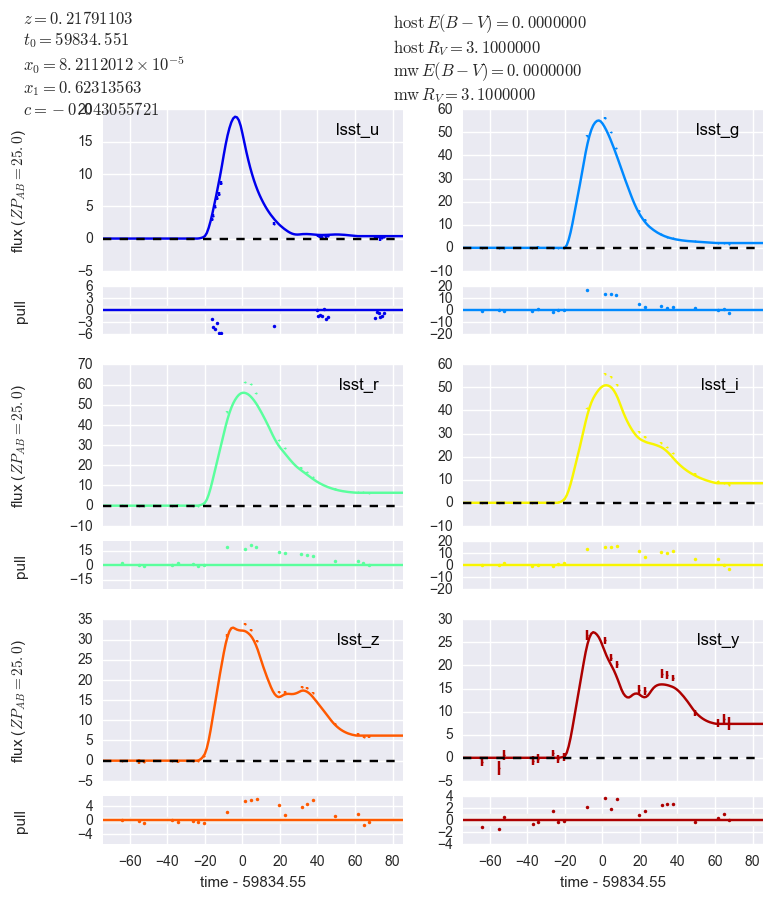

In [15]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)

### Inferring the model parameters from the data

First we will use a max likelihood method for estimating the model parameters

In [16]:
fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

In [17]:
fitresChar = ans.ResChar.fromSNCosmoRes(fitres)

In [18]:
fitresChar.salt_covariance_linear()

,mB,x1,c
mB,0.000662,0.000285,0.000408
x1,0.000285,0.005307,-0.000043
c,0.000408,-0.000043,0.000400


In [19]:
fitresChar.mu_variance_linear()** 0.5

          mB        x1         c
mB  0.000662  0.000285  0.000408
x1  0.000285  0.005307 -0.000043
c   0.000408 -0.000043  0.000400 [ 1.    0.14 -3.1 ]


0.046923872200400916

## What if we did not know z?

In [20]:
fitres_z = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c', 'z'], guess_z=True, 
                          bounds=dict(z=(0.1, 0.35)),
                          modelcov=True)

In [21]:
fitresChar_z = ans.ResChar.fromSNCosmoRes(fitres_z)

In [22]:
fitresChar_z.mu_variance_linear()**0.5

          mB        x1         c
mB  0.000663  0.000330  0.000397
x1  0.000330  0.006588 -0.000302
c   0.000397 -0.000302  0.000459 [ 1.    0.14 -3.1 ]


0.055607793350969749

## Now we repeat this in a different method

The maximum likelihood method above is not good if the likelihood are too far from the Gaussian. A method to sample posteriors is better.
Such a method can be based on a MCMC run.  We do that here by the following code

In [24]:
samples = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

These are samples of these parameters :

In [50]:
ans.ResChar.fromSNCosmoRes(samples).samples.head()

,t0,x0,x1,c
0,59834.343057,0.000092,0.721100,-0.078284
1,59834.331780,0.000092,0.680131,-0.084074
2,59834.331780,0.000092,0.680131,-0.084074
3,59834.417606,0.000091,0.606346,-0.067696
4,59834.425652,0.000091,0.597005,-0.066437


In [108]:
tstart = time.time()
samples_z_nomodelcov = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                                       bounds=dict(z=(0.1, 0.5)), modelcov=False)
tend = time.time()
print(tend-tstart)

934.204557896


In [110]:
tstart = time.time()
samples_z = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                           bounds=dict(z=(0.2, 0.6)), modelcov=True)
tend = time.time()
print(tend-tstart)

1429.62573004


In [52]:
ans.ResChar.fromSNCosmoRes(samples_z).samples.head()

,z,t0,x0,x1,c
0,0.276657,59834.633526,0.000082,1.224459,-0.000572
1,0.276512,59834.556114,0.000081,1.159863,0.001597
2,0.276512,59834.556114,0.000081,1.159863,0.001597
3,0.276512,59834.556114,0.000081,1.159863,0.001597
4,0.276505,59834.559163,0.000082,1.154477,-0.000465


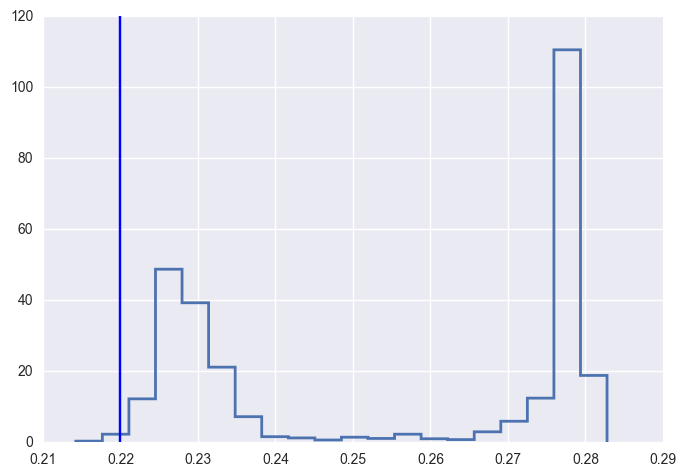

In [57]:
fig, ax = plt.subplots()
ans.ResChar.fromSNCosmoRes(samples_z).samples.z.hist(histtype='step', bins=20, lw=2., alpha=1., normed=1, ax=ax)
ax.axvline(0.22)

### Plots

In [101]:
import corner

The origin of the bimodal distribution on `mu` can be seen by exploring the scatter plots of the samples. 
For the case where `z` was known, we can look at the histograms and scatter plots of pairs of variables:

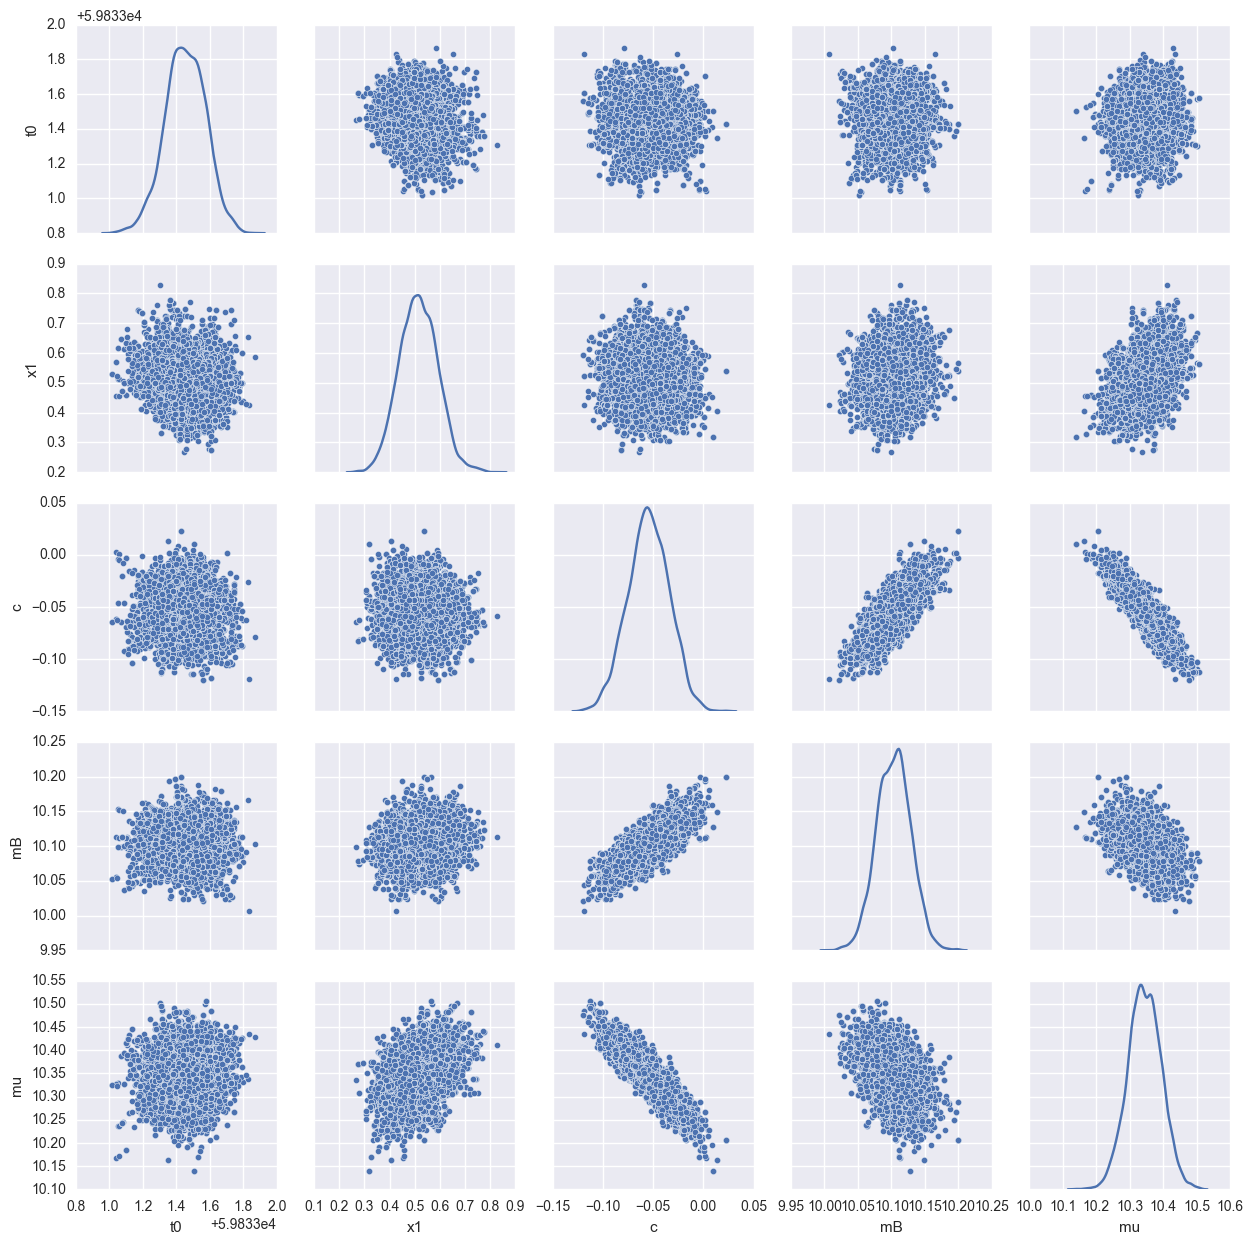

In [100]:
sns.pairplot(ans.ResChar.fromSNCosmoRes(samples).salt_samples(), kind='scatter', diag_kind='kde')

Consequently, the posterior distributions can be plotted and they are fine

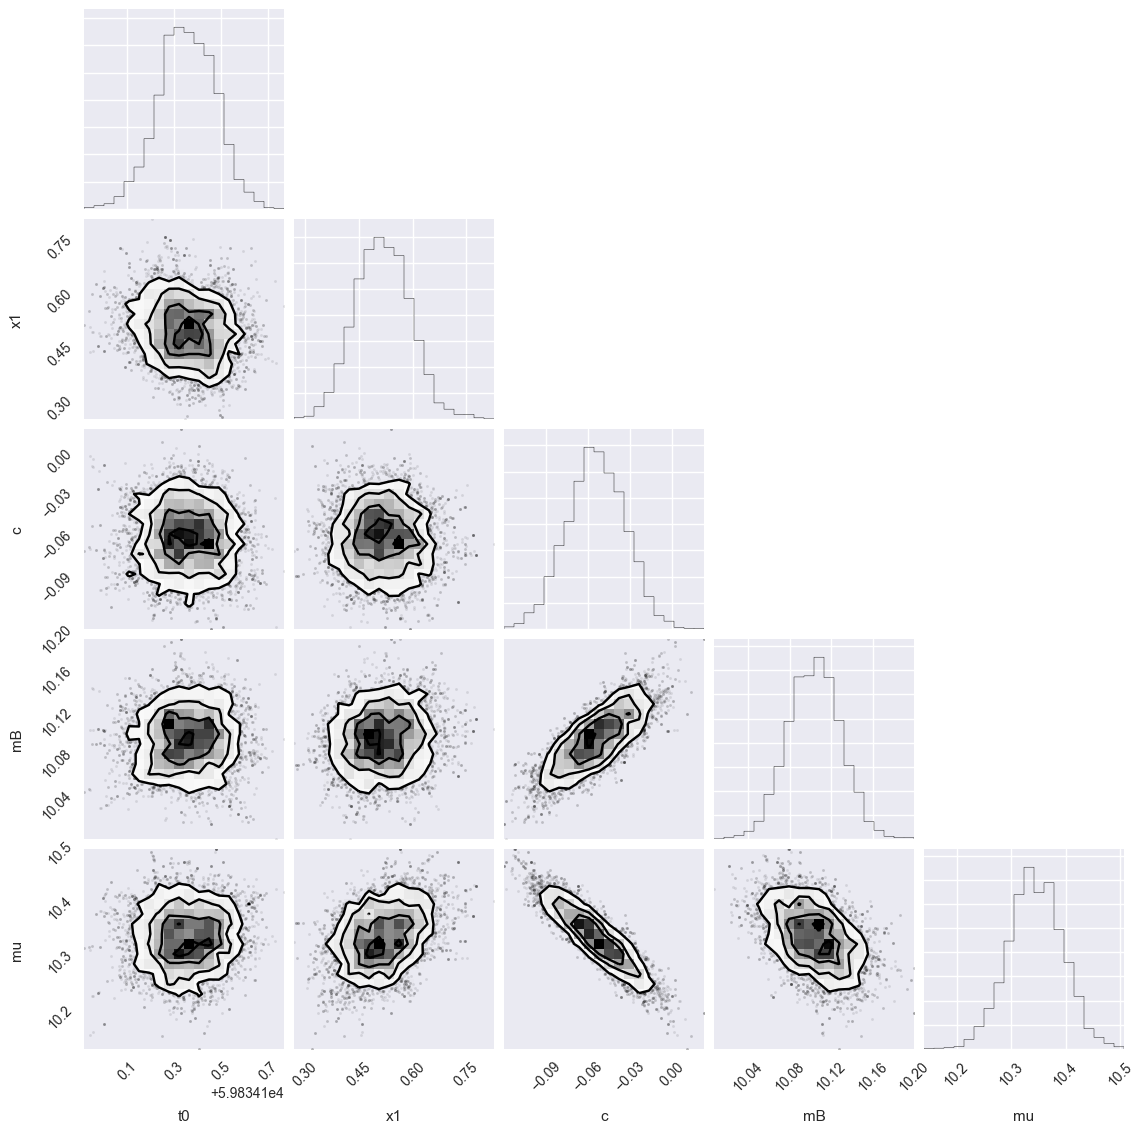

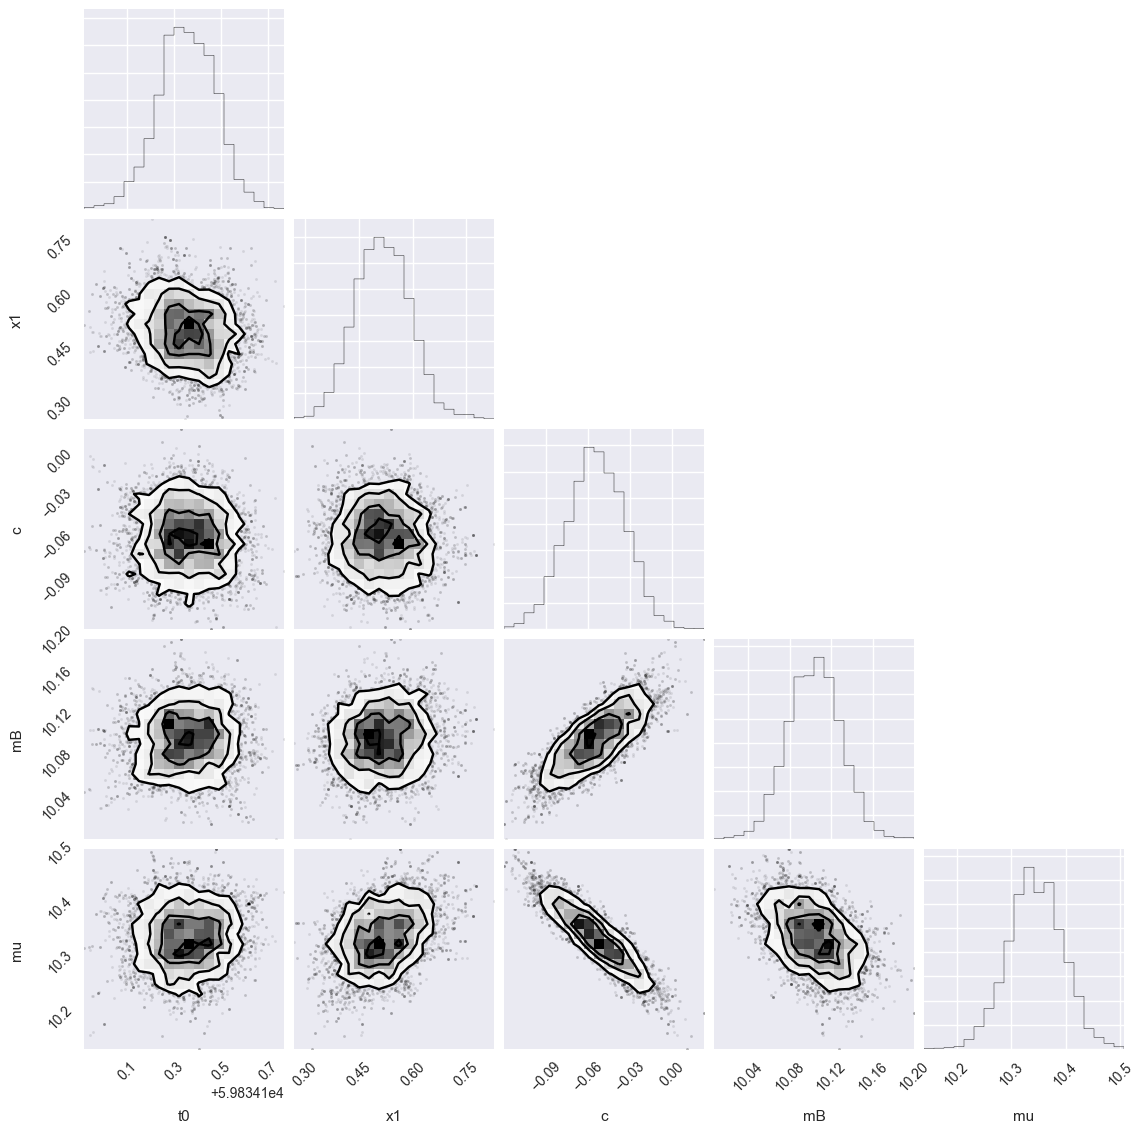

In [102]:
corner.corner(ans.ResChar.fromSNCosmoRes(samples).salt_samples(), lw=2., alpha=1.)

However, when the redshifts are not known, this is what the scatter plots look like:

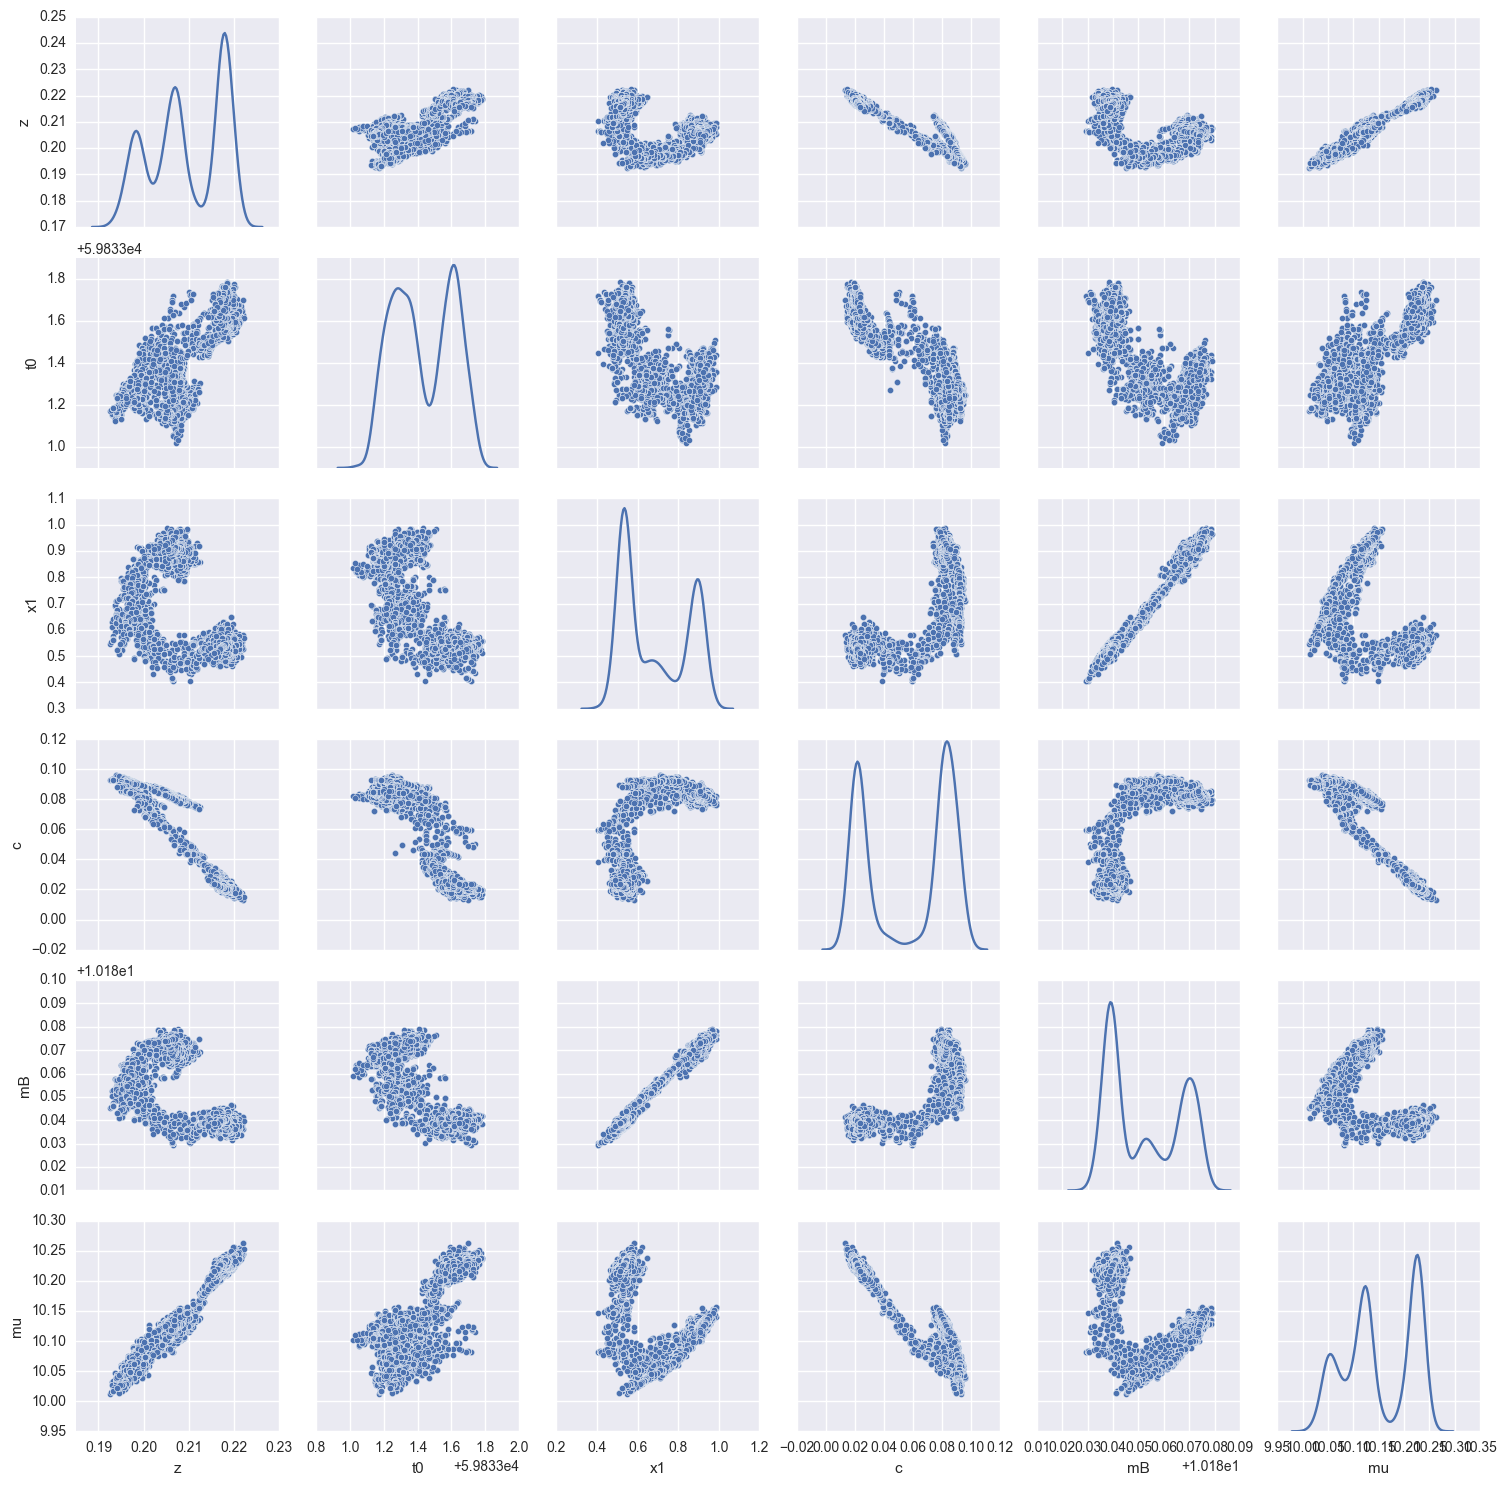

In [115]:
sns.pairplot(ans.ResChar.fromSNCosmoRes(samples_z_nomodelcov).salt_samples(), diag_kind='kde', kind='scatter')

Leading to posterior distributions like:

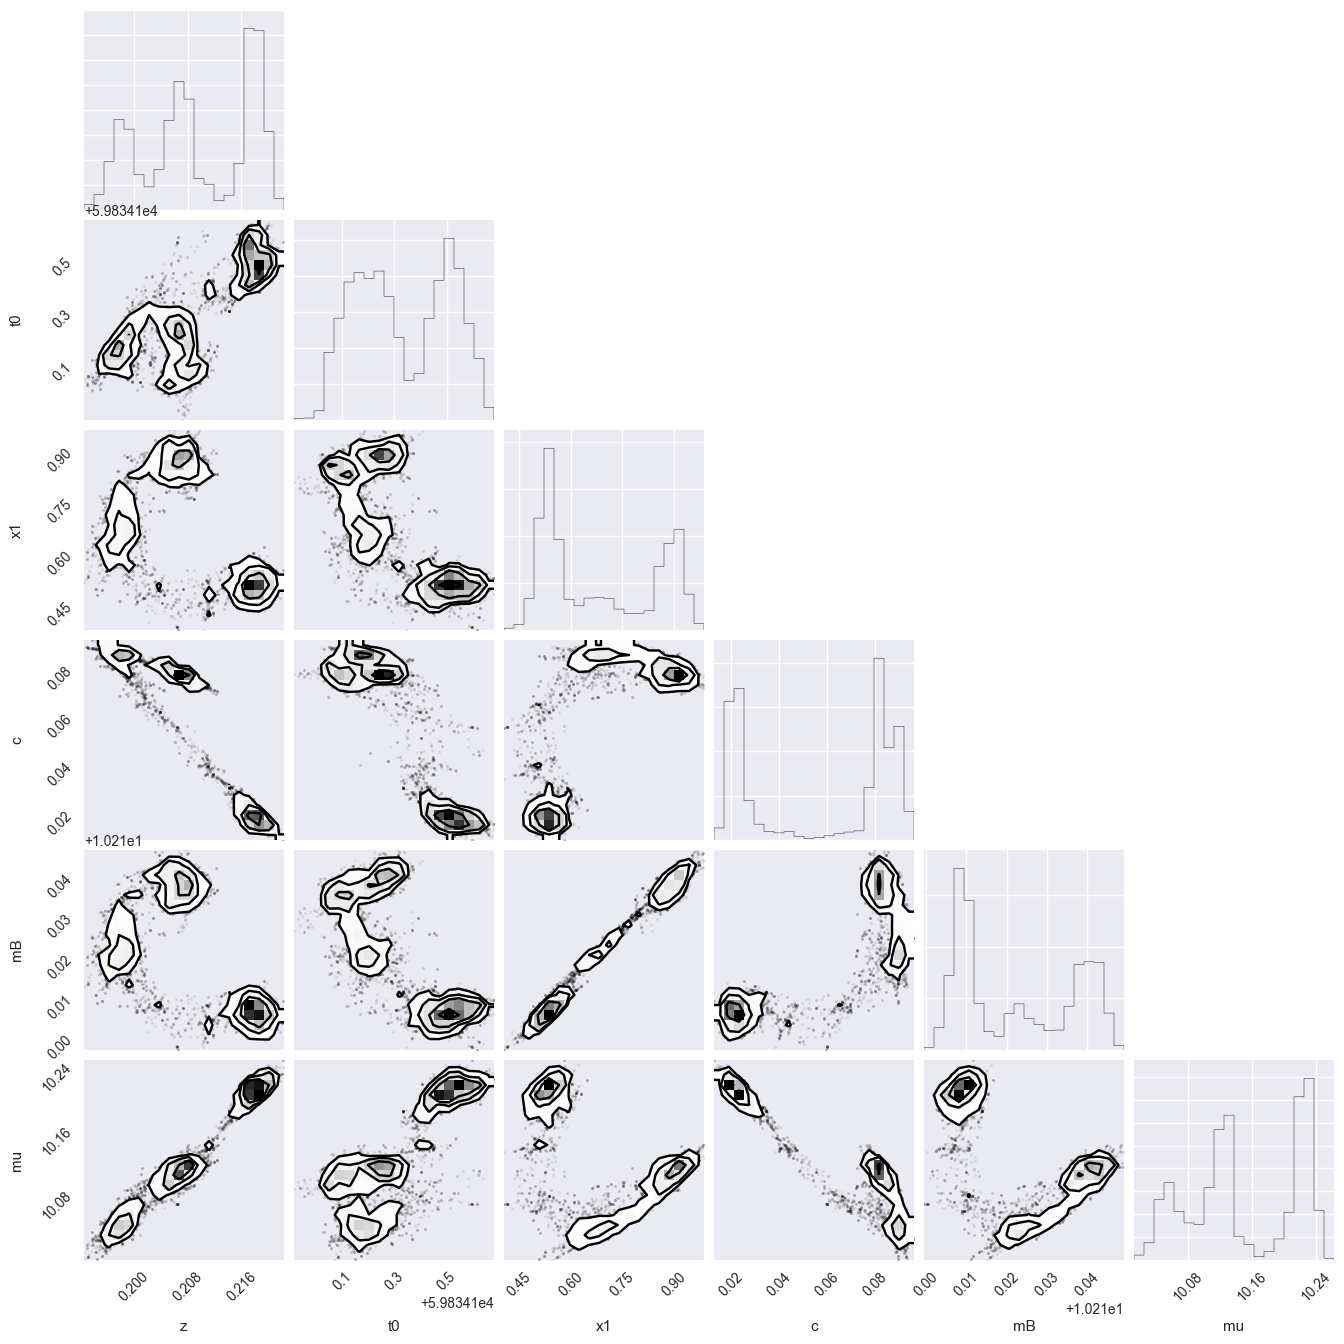

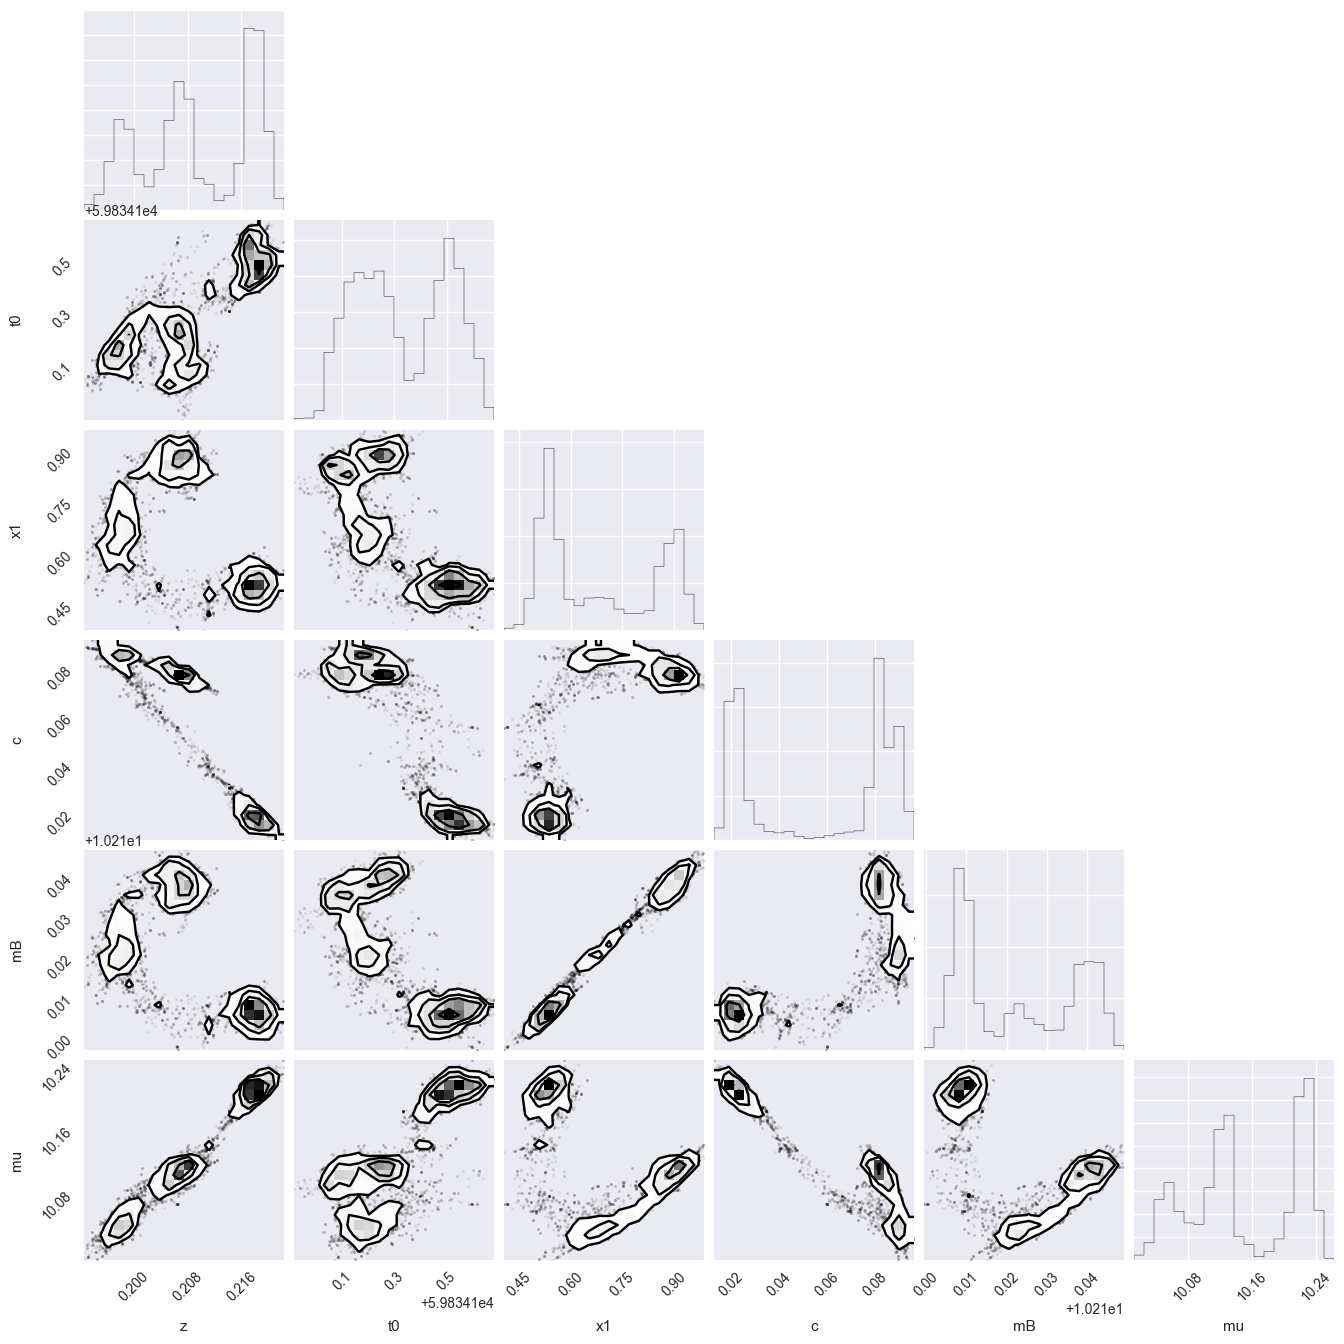

In [114]:
corner.corner(ans.ResChar.fromSNCosmoRes(samples_z_nomodelcov).salt_samples(), lw=2., alpha=1.)